In [1]:
%matplotlib inline

import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import xarray as xr

plt.style.use("ggplot")

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Extract EMEP data for stations

Extract annual time series of EMEP data for point locations.

## 1. Read stations list

Dataframe must have a unique `station_id` column and columns named `latitude` and `longitude`.

In [2]:
# Read stations
xl_path = r"kari_n_dep.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="Sheet 1")
stn_df.dropna(subset=["latitude", "longitude"], inplace=True)
stn_df.head()

,country,site_ID,Lake_ID,Lake_name,station_id,latitude,longitude,surface.area,altitude,Urban,Agriculture,Forest,catchment.area
0,FI,1000,17019,Ylimmäinen,17019_1000,63.26044,26.41588,118.810,145.22,6.352445,7.300675,82.428767,549.49
1,FI,1001,17026,Kumpunen,17026_1001,63.08079,26.75306,100.722,103.71,5.796745,9.682628,82.189525,1042.29
2,FI,1002,17071,Savijärvi,17071_1002,63.40806,26.53637,109.262,102.71,2.330188,14.279843,78.737712,11677.57
3,FI,10021,52757,Ainijärvi,52757_10021,67.76718,29.45693,69.176,266.10,0.451908,0.000000,62.787134,708.55
4,FI,1003,17276,Murtonen,17276_1003,62.96668,27.13723,110.900,134.70,5.436698,4.109958,88.665182,949.94


## 2. Get EMEP data

Data from 2000 onwards are generated by EMEP and hosted on met.no's Thredds server (see [here](https://www.emep.int/mscw/mscw_moddata.html) and [here](https://thredds.met.no/thredds/catalog/data/EMEP/2019_Reporting/catalog.html)).

### 2.1. Read EMEP data

In [3]:
# List files to process
file_paths = [
    f"https://thredds.met.no/thredds/dodsC/data/EMEP/2019_Reporting/EMEP01_L20EC_rv4_33_year.{year}met_{year}emis_rep2019.nc"
    for year in range(2000, 2017)
]

# Data after 2016 have a different naming convention/url (see links above and update if necessary)
file_paths += [
    r"https://thredds.met.no/thredds/dodsC/data/EMEP/2019_Reporting/EMEP01_L20EC_rv4_33_year.2017met_2017emis.nc",
    r"https://thredds.met.no/thredds/dodsC/data/EMEP/2020_Reporting/EMEP01_rv4_35_year.2018met_2018emis.nc",
]

In [4]:
# Open datasets
ds = xr.open_mfdataset(
    file_paths,
    combine="by_coords",
)
ds

<xarray.Dataset>
Dimensions:             (lat: 520, lon: 1200, time: 19)
Coordinates:
  * lon                 (lon) float64 -29.95 -29.85 -29.75 ... 89.75 89.85 89.95
  * lat                 (lat) float64 30.05 30.15 30.25 ... 81.75 81.85 81.95
  * time                (time) datetime64[ns] 2000-07-02 ... 2018-07-02T12:00:00
Data variables: (12/49)
    SURF_ugN_NOX        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ugN_RDN        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ugN_OXN        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_PREC           (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_SOX            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_OXN            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    ...                  ...
    SURF_ug_ECFINE      (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_ECCOARSE    (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25        (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM_coarse   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM10_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
Attributes:
    vert_coord:                      atmosphere_hybrid_sigma_pressure_coordinate
    Conventions:                     CF-1.6
    model:                           EMEP_MSC-W
    author_of_run:                   emepctm group
    created_date:                    20190729
    created_hour:                    223527.486
    projection:                      lon lat
    period_type:                     fullrun
    run_label:                       rv4_33
    lastmodified_date:               20190801
    lastmodified_hour:               013954.816
    DODS_EXTRA.Unlimited_Dimension:  time

In [5]:
# Load data from URL into memory to improve performance later
ds = ds.load()

In [6]:
# Pars of interest
par_list = [
    "DDEP_SOX_m2Grid",
    "WDEP_SOX",
    "DDEP_OXN_m2Grid",
    "WDEP_OXN",
    "DDEP_RDN_m2Grid",
    "WDEP_RDN",
]

# Check N units are consistent
for par in par_list:
    unit = ds[par].attrs["units"]
    print(f"{par: <20}", unit)
    assert unit in ["mgS/m2", "mgN/m2"], "Units not consistent."

DDEP_SOX_m2Grid      mgS/m2
WDEP_SOX             mgS/m2
DDEP_OXN_m2Grid      mgN/m2
WDEP_OXN             mgN/m2
DDEP_RDN_m2Grid      mgN/m2
WDEP_RDN             mgN/m2


In [7]:
# Calculate total oxidised S
ds["DEP_SOX"] = ds["WDEP_SOX"] + ds["DDEP_SOX_m2Grid"]
ds["DEP_SOX"].attrs["units"] = "mgS/m2"

# Calculate total oxidised N
ds["DEP_OXN"] = ds["WDEP_OXN"] + ds["DDEP_OXN_m2Grid"]
ds["DEP_OXN"].attrs["units"] = "mgN/m2"

# Calculate total reduced N
ds["DEP_RDN"] = ds["WDEP_RDN"] + ds["DDEP_RDN_m2Grid"]
ds["DEP_RDN"].attrs["units"] = "mgN/m2"

# Calculate total N
ds["DEP_TOTN"] = (
    ds["WDEP_OXN"] + ds["WDEP_RDN"] + ds["DDEP_OXN_m2Grid"] + ds["DDEP_RDN_m2Grid"]
)
ds["DEP_TOTN"].attrs["units"] = "mgN/m2"

### 2.2. Extract time series for stations

In [8]:
par_list = par_list + ["DEP_SOX", "DEP_OXN", "DEP_RDN", "DEP_TOTN"]
df_list = []
for idx, row in stn_df.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    stn_id = row["station_id"]

    # Get time series
    df = (
        ds[par_list]
        .sel(lat=lat, lon=lon, method="nearest")
        .to_dataframe()
        .reset_index()
    )
    df["station_id"] = stn_id
    df["year"] = df["time"].dt.year

    df_list.append(df)

# Combine results
df = pd.concat(df_list, sort=True).reset_index(drop=True)
df = df[["station_id", "year"] + par_list]
par_unit = [i + "_mgpm2" for i in par_list]
df.columns = ["station_id", "year"] + par_unit

df.head()

,station_id,year,DDEP_SOX_m2Grid_mgpm2,WDEP_SOX_mgpm2,DDEP_OXN_m2Grid_mgpm2,WDEP_OXN_mgpm2,DDEP_RDN_m2Grid_mgpm2,WDEP_RDN_mgpm2,DEP_SOX_mgpm2,DEP_OXN_mgpm2,DEP_RDN_mgpm2,DEP_TOTN_mgpm2
0,17019_1000,2000,40.921577,248.558502,101.803413,187.667526,18.767439,99.927971,289.480072,289.470947,118.695412,408.166321
1,17019_1000,2001,37.575005,231.888824,92.784294,158.181976,18.184000,91.716286,269.463837,250.966278,109.900284,360.866547
2,17019_1000,2002,31.201347,161.748428,82.918716,137.376343,19.334312,88.027840,192.949768,220.295059,107.362152,327.657196
3,17019_1000,2003,41.823738,190.485718,100.654686,152.423859,21.297756,78.079506,232.309448,253.078552,99.377258,352.455811
4,17019_1000,2004,32.780762,162.276215,96.184929,155.818100,20.488699,76.437019,195.056976,252.003021,96.925720,348.928772


### 2.3. Save and plot

In [9]:
# Save
out_csv = r"./csv/europe/emep_dep_thredds.csv"
df.to_csv(out_csv, index=False)

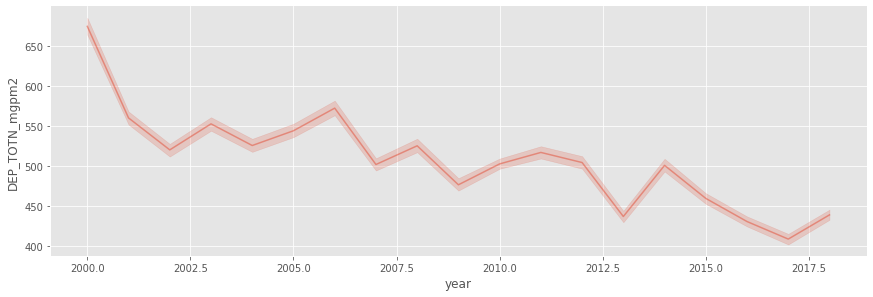

In [10]:
sn.relplot(
    data=df,
    x="year",
    y="DEP_TOTN_mgpm2",
    height=4,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
)